In [2]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import plot_hyb
import predict_Beta_I
import seir_discrete
import choice_start_day
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## stuff

In [17]:
folder = 'chelyabinsk_0.3_sampled/' 

full_pop = 795336
I0 = 10
prevalence_files = glob.glob(folder+'/**/prevalence*.csv', recursive=True)
incidence_files = glob.glob(folder+'/**/incidence*.csv', recursive=True)

In [5]:
inc_f = incidence_files[0]
params = inc_f.split('\\')[1]
params

'alpha_0.05_lmbd_0.1'

In [6]:
params.split('_')[3]

'0.1'

In [51]:
def get_comparts(full_pop=795336, I0=10, 
                 alpha_v=1, lambda_v=1, pr_f='', inc_f=''):
    
    df_p = pd.read_csv(pr_f, sep='\t')
    df_i = pd.read_csv(inc_f, sep='\t')
    
    # full_pop * alpha - (E0+I0) = S
    S0 = round(full_pop * alpha_v) - df_p['H1N1'].values[0]
    R0 = full_pop - S0 - df_p['H1N1'].values[0]
    E0 = df_p['H1N1'].values[0] - I0
    S0, E0, I0, R0, df_p['H1N1'].values[0]
    
    EI = df_p['H1N1'].values
    diff_EI = df_i['H1N1'].values
    # diff EI -- новые случае ЕИ. тк exposed первые два дня, 
    # то суммируем по два дня == exposed
    E = pd.Series(diff_EI).rolling(2).sum().values
    E[0] = E0

    # I
    I = EI - E
    
    # S
    epid_length = diff_EI.shape[0] - 1
    S = [S0, *(np.array([S0]*epid_length) - diff_EI[1:].cumsum())]
    
    fin_comps = pd.DataFrame([S,E,I]).T
    fin_comps.columns=['S_H1N1','E_H1N1','I_H1N1']
    fin_comps['R_H1N1'] = fin_comps.apply(lambda x: full_pop-x.sum(), axis=1)
    
    zero_idx = fin_comps[(fin_comps['E_H1N1']==0)&(fin_comps['I_H1N1']==0)]
    
    if zero_idx.shape[0]:
        fin_comps.iloc[zero_idx.index[0]:] = 0
    
    fin_comps['beta_H1N1'] = - (fin_comps.S_H1N1.diff() / (fin_comps.S_H1N1 * 
                                                           fin_comps.I_H1N1)
                               ).fillna(0)
    
    return fin_comps

In [16]:
folder = 'chelyabinsk_0.3_sampled/' 

full_pop = 795336
I0 = 10
prevalence_files = glob.glob(folder+'/**/prevalence*.csv', recursive=True)
incidence_files = glob.glob(folder+'/**/incidence*.csv', recursive=True)

for pr_f, inc_f in zip(prevalence_files, incidence_files):
    # из полного пути берем название файла с параметрами
    #pr_file_n = pr_f.split('\\')[-1]
    params = inc_f.split('\\')[1]
    print(inc_f)
    # берем значения параметров
    alpha_v = float(params.split('_')[1])
    lambda_v = float(params.split('_')[3])
    
    df_comps = get_comparts(full_pop=full_pop, I0=I0, 
                            alpha_v=alpha_v, lambda_v=lambda_v, 
                            pr_f = pr_f, inc_f = inc_f)
    
    df_comps.to_csv(folder + params + '_seirb_seed' + inc_f.split('seed')[-1], 
                    index=False)
    #print(file_n, alpha_v, lambda_v)

chelyabinsk_0.3_sampled\alpha_0.05_lmbd_0.1\incidence_seed_0.csv


NameError: name 'get_comparts' is not defined

In [5]:
folder + params + '_seirb_seed' + inc_f.split('seed')[-1]

'chelyabinsk_0.3_sampled/alpha_0.05_lmbd_0.1_seirb_seed_0.csv'

In [4]:
s_files = glob.glob(folder+'alpha*.csv')
len(s_files)

1910

In [5]:
folder

'chelyabinsk_0.3_sampled/'

In [6]:
df['I_H1N1'].max()

NameError: name 'df' is not defined

279


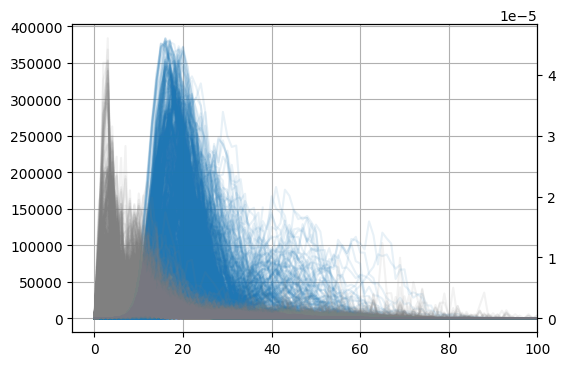

In [18]:
s_files = glob.glob(folder+'alpha*.csv')
len(s_files)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()
bad = []

for i in s_files:
    df = pd.read_csv(i)
    if df['I_H1N1'].max() >= 10000:
        ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1)
        ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1)
    else:
        bad.append(i)
        #print(i)
        
print(len(bad))
ax.set_xlim(-5, 100)
ax.grid()



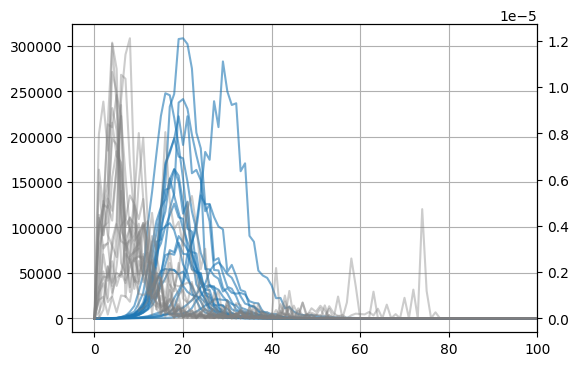

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

for i in random.sample(s_files, 20):
    df = pd.read_csv(i)
    if df['I_H1N1'].max() >= 10000:
        ax.plot(df.I_H1N1, color='tab:blue', alpha=0.6)
        ax_b.plot(df.beta_H1N1, color='gray', alpha=0.4)
    else:
        bad+=1
        #print(i)
ax.set_xlim(-5, 100)
ax.grid()

In [73]:
len(s_files)

1910

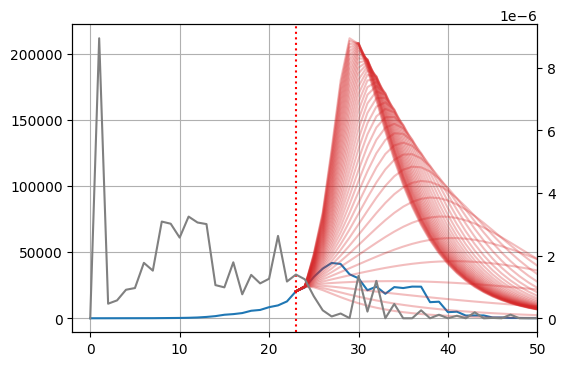

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()
bad = 0

df = pd.read_csv(s_files[810])

if df['I_H1N1'].max() >= 10000:
    ax.plot(df.I_H1N1, color='tab:blue', alpha=1)
    
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
    if end_df.shape[0]:
        seed_df = seed_df.iloc[:end_df.index[0]].copy()
        
    real_peakt = seed_df.I.argmax()
    real_peakh = seed_df.I.max()
    
    switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.02)
    ax_b.plot(seed_df.Beta, color='gray', alpha=1)
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)
    
    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    for b in np.arange(0.0, 8e-6, 2e-7):
        #ax_beta.plot(b, ls='--', color='tab:green')
        S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                           sigma, gamma, stype='d', 
                                           beta_t=False).T
        ax.plot(ts+switch_day, I, color='tab:red', ls='-', alpha=0.3)

        predicted_peakt = I.argmax()+switch_day
        predicted_peakh = I.max()

        pt_err = abs(real_peakt - predicted_peakt)
        ph_err = abs(real_peakh - predicted_peakh)
        #traj_err = rmse(df_b.I_H1N1.iloc[switch_day:], I) 
        #res_dict[b] = [pt_err,ph_err,traj_err]
    
    
    
ax.axvline(switch_day, ls=':', color='red')    
ax.set_xlim(-2, 50)
ax.grid()    

In [55]:
def func(t, b0, phi, q):
    return b0*( (1-phi)*np.exp(-q*t) + phi)

start_day = seed_df.I.argmax()-7
beta_e = seed_df.Beta.expanding(1).mean().bfill()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

ax.plot(seed_df.I)
ax_b.plot(seed_df.Beta, alpha=0.5)
ax_b.plot(beta_e, color='gray', ls='--')

days = np.arange(switch_day, seed_df.shape[0])
b0 = beta_e[switch_day]#*5
phi = (1/2)*b0
q = 0.1

ax.axvline(switch_day, ls=':', color='red')
ax_b.plot(days,
          func(days-switch_day , b0, phi, q), 
          color='red')

y0 = df.iloc[switch_day,:4].values
bb = func(days-switch_day , b0, phi, q)
S,E,I,R = seir_discrete.seir_model(y0, days-switch_day, bb,
                                   sigma, gamma, stype='d', 
                                   beta_t=True).T
ax.plot(days, I, color='orange', ls='-', 
        alpha=1, label='modeled I, expanding')

ax.grid()
ax.legend()

np.float64(1.8e-06)

In [54]:
I

array([ 37533.        ,  36055.        ,  42591.32841053,  50863.14447728,
        60120.58594145,  70048.92700503,  80247.12174747,  90172.58239031,
        99171.40018048, 106556.13753381, 111716.29994041, 114233.19640525,
       113961.74755834, 111049.8999696 , 105890.64134632,  99028.22107333,
        91053.3398921 ,  82517.08108321,  73877.90464321,  65481.12020128,
        57561.97636902,  50261.85567024,  43649.18389088,  37739.81934762,
        32514.37932617,  27931.73962151,  23938.90520139,  20477.85512011,
        17490.0524512 ,  14919.24634556,  12713.07578317,  10823.86257854,
         9208.87552507,   7830.26400148,   6654.79681565,   5653.49693247,
         4801.23102524,   4076.29097431,   3459.98969473])

In [ ]:
i=0

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_beta = ax.twinx()

folder = 'full_chel_recalc/'
df_b = pd.read_csv(f'{folder}/seirb_seed_{i}.csv')
fin = df_b.shape[0]
real_peakt = df_b.I_H1N1.argmax()
real_peakh = df_b.I_H1N1.max()
st_day = real_peakt - 7
ax.plot(df_b.I_H1N1)

betas = df_b.beta_H1N1
ax_beta.plot(betas, color='gray', alpha=0.4, label='beta from df')


ax.axvline(st_day, ls=':', color='red')

y0 = df_b.iloc[st_day,:4].values
ts = np.arange(fin-st_day)
sigma = 1/2
gamma = 1/6

res_dict = dict()
for b in np.arange(0.0, 2e-5, 2e-7):
    #ax_beta.plot(b, ls='--', color='tab:green')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=False).T
    ax.plot(ts+st_day, I, color='tab:red', ls='-', alpha=0.3)
    
    predicted_peakt = I.argmax()+st_day
    predicted_peakh = I.max()

    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)
    traj_err = rmse(df_b.I_H1N1.iloc[st_day:], I) 
    res_dict[b] = [pt_err,ph_err,traj_err]
    
    
    
best_b = pd.DataFrame.from_dict(res_dict).T.reset_index()
best_b.columns = ['beta', 'pt_err', 'ph_err', 'traj_err']

best_b_peak_time = best_b.nsmallest(1,'traj_err').iloc[0,0]   
S,E,Ib,R = seir_discrete.seir_model(y0, ts, best_b_peak_time, 
                                     sigma, gamma, stype='d', 
                                   beta_t=False).T
ax.plot(ts+st_day, Ib, color='yellow', ls='-', alpha=1, lw=2,
                    label=f'I; best beta (traj_err) {best_b_peak_time:.7f}')   


best_b_peak_time = best_b.nsmallest(1,'ph_err').iloc[0,0]   
S,E,Ib,R = seir_discrete.seir_model(y0, ts, best_b_peak_time, 
                                     sigma, gamma, stype='d', 
                                   beta_t=False).T
ax.plot(ts+st_day, Ib, color='lightgreen', ls='-', alpha=1, lw=2,
                    label=f'I; best beta (ph_err) {best_b_peak_time:.7f}')         


S,E,Ib,R = seir_discrete.seir_model(y0, ts, betas.iloc[st_day:].values, 
                                     sigma, gamma, stype='d', 
                                   beta_t=True).T
ax.plot(ts+st_day, Ib, color='orange', ls='-', alpha=1, lw=2,
                    label=f'I; beta real')         

ax.grid()
#ax.set_xlim(40,80)
ax.legend()

In [143]:
choice_start_day.cpoint_roll_var(seed_df, thresh = 0.05)

np.int64(12)

In [108]:
df.iloc[0,:4].sum()

np.float64(795336.0)

In [96]:
full_pop*0.01

7953.360000000001

In [103]:
df[df['I_H1N1']>=full_pop*0.01].index[0]

np.int64(20)

(-1.0, 50.0)

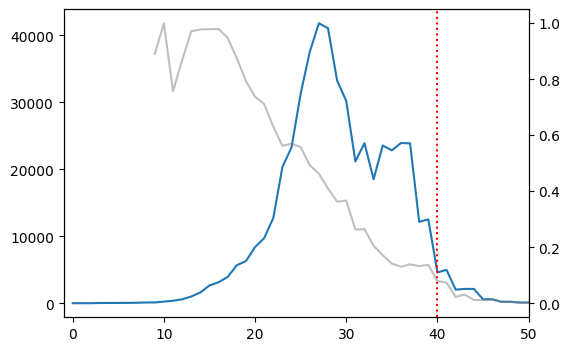

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

mvt = seed_df.Beta.rolling(10).mean()
#mvt.plot()

ax.plot(seed_df.I, color='tab:blue', alpha=1)

scaler = MinMaxScaler()
scaled_varv = scaler.fit_transform(mvt.values.reshape(-1, 1))
thresh = 0.1

switch_day = np.nanmin(np.where(scaled_varv < thresh)[0])   
plt.axvline(switch_day, ls=':', color='red')

ax_b.plot(scaled_varv, color='gray', alpha=0.5)
plt.xlim(-1, 50)

In [51]:
np.where(R==G)

(array([], dtype=int64),)

In [53]:
data = df.Beta.values
n = len(data)
tau = np.arange(1,n)
criterion = 1*np.log(n) #Bayesian Information Criterion
#criterion = 2

eps = 1.e-8 #to avoid zeros in denominator

std0 = np.std(data)
std1 = np.asarray([np.std(data[0:i]) for i in range(1,n)],dtype=float) + eps
std2 = np.asarray([np.std(data[i:]) for i in range(1,n)],dtype=float) + eps
R = n*np.log(std0) - tau*np.log(std1) - (n-tau)*np.log(std2)
G  = np.max(R)
cpoint = int(np.where(R==G)[0]) + 1

teststat = 2*G

TypeError: only length-1 arrays can be converted to Python scalars

In [80]:
s_files[:3]

['chelyabinsk_0.3_sampled\\alpha_0.05_lmbd_0.1_seirb_seed_0.csv',
 'chelyabinsk_0.3_sampled\\alpha_0.05_lmbd_0.1_seirb_seed_1.csv',
 'chelyabinsk_0.3_sampled\\alpha_0.05_lmbd_0.1_seirb_seed_2.csv']

In [82]:
s_files[0].split('\\')

['chelyabinsk_0.3_sampled', 'alpha_0.05_lmbd_0.1_seirb_seed_0.csv']

In [118]:
seed_df = pd.read_csv(s_files[810])
seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()
seed_df

,S,E,I,R,Beta
0,357889.0,2.0,10.0,437435.0,-0.000000e+00
1,357857.0,34.0,10.0,437435.0,8.942119e-06
2,357855.0,34.0,12.0,437435.0,4.657380e-07
3,357846.0,11.0,44.0,437435.0,5.716019e-07
4,357831.0,24.0,46.0,437435.0,9.112876e-07
...,...,...,...,...,...
60,271895.0,0.0,4.0,523437.0,-0.000000e+00
61,271895.0,0.0,4.0,523437.0,-0.000000e+00
62,271895.0,0.0,1.0,523440.0,-0.000000e+00
63,271895.0,0.0,1.0,523440.0,-0.000000e+00


## разделяем на выборки

In [3]:
parameters = pd.DataFrame(columns = ['file', 'seed', 'alpha', 'lambda'])

for file in good_files:
    file_name = file.split('\\')[1]
    alpha_v = float(file_name.split('_')[1])
    lambda_v = float(file_name.split('_')[3])
    seed_n = int(file_name.split('_')[-1][:-4])
    
    parameters = pd.concat([parameters,
                            pd.DataFrame({'file':[file],
                                          'seed':[seed_n],
                                          'alpha':[alpha_v],
                                          'lambda':[lambda_v]})
                           ], ignore_index=True) 

# save the results to a csv file
#parameters.to_csv('chel_03_seeds_parameters.csv', index=False)

NameError: name 'good_files' is not defined

In [3]:
df_orig = pd.read_csv('chel_03_seeds_parameters.csv')
# Чтобы в каждом наборе параметров было минимум 2 файла
# keep = False, чтобы и первые, и последние строки считались за дубликат
dfp = df_orig[df_orig.duplicated(['alpha', 'lambda'], keep=False)]

X = dfp[['file']]
y = dfp[['alpha', 'lambda']]

X_train, X_test = train_test_split(X, test_size=0.2, 
                                   random_state=42, stratify=y)
y = y.loc[X_train.index]
X_train, X_val = train_test_split(X_train, test_size=0.2, 
                                  random_state=42, stratify=y)

In [4]:
X_train.shape, X_test.shape, X_val.shape

((1042, 1), (326, 1), (261, 1))

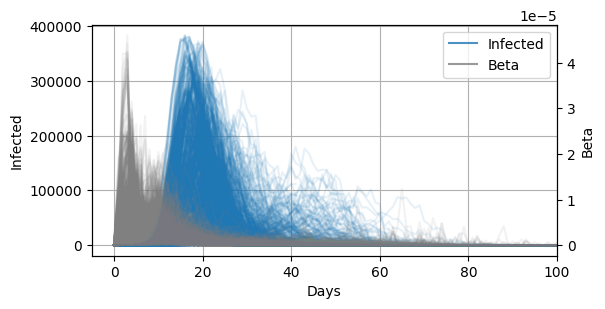

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()
bad = []

for i in [*X_train.values.flatten(), 
          *X_val.values.flatten()]:
    df = pd.read_csv(i)
    if df['I_H1N1'].max() >= 10000:
        ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1)
        ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1)
    else:
        bad.append(i)
        #print(i)
        
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1, label='Infected')
l2 = ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1, label='Beta')        


ax.set_xlim(-5, 100)
ax.grid()

lns = l1+l2
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')

plt.savefig(f'results/chel_diff/train_data.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')    

In [148]:
(20000*100) / 780000

2.5641025641025643

0


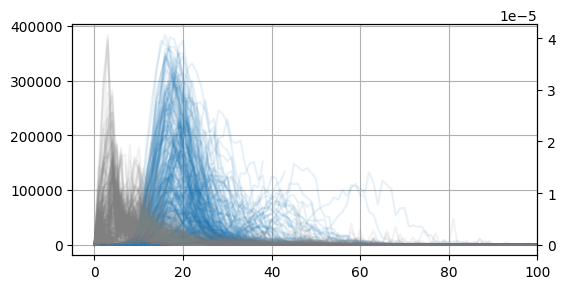

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()
bad = []

for i in X_test.values.flatten():
    df = pd.read_csv(i)
    if df['I_H1N1'].max() >= 10000:
        ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1)
        ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1)
    else:
        bad.append(i)
        #print(i)
        
print(len(bad))
ax.set_xlim(-5, 100)
ax.grid()

In [9]:
seed_numbers

[array([], dtype=object)]

In [ ]:
'''
регрессия ext. хорошо прогнозирует бету,
но этого недостаточно для хорошего прогноза Infected
из-за неоднородности агентной модели?
'''

last value 


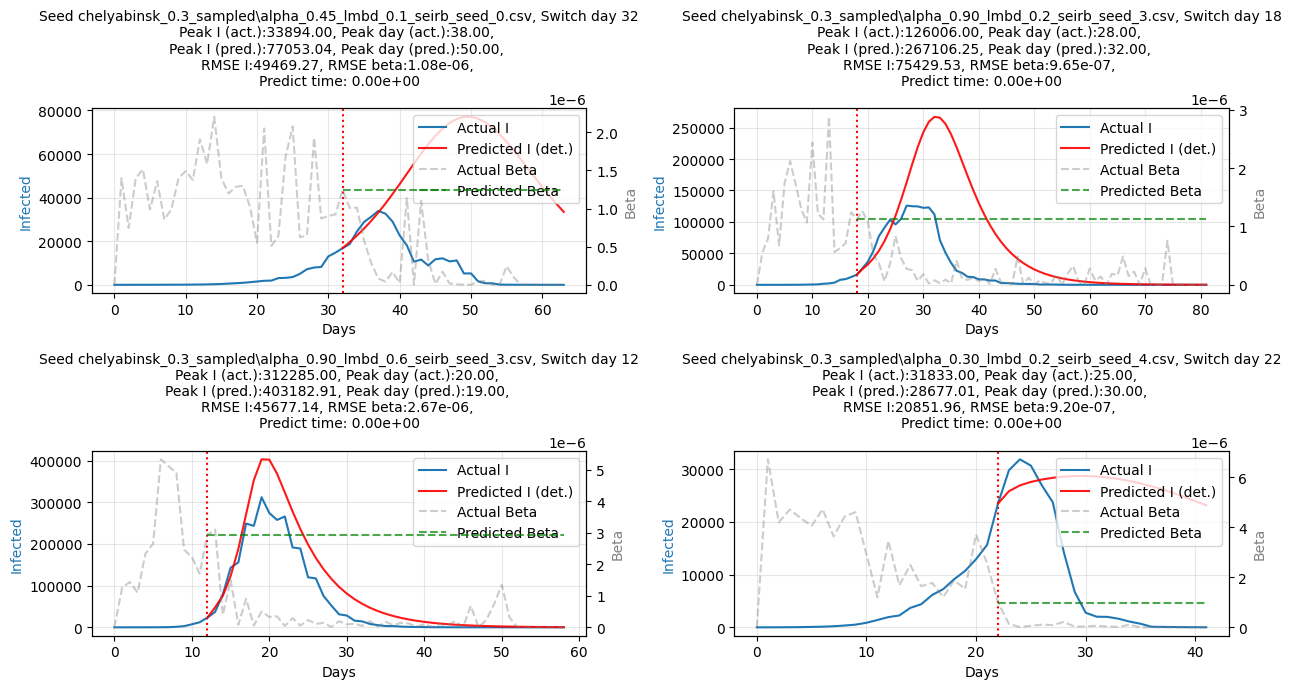

rolling mean last value 


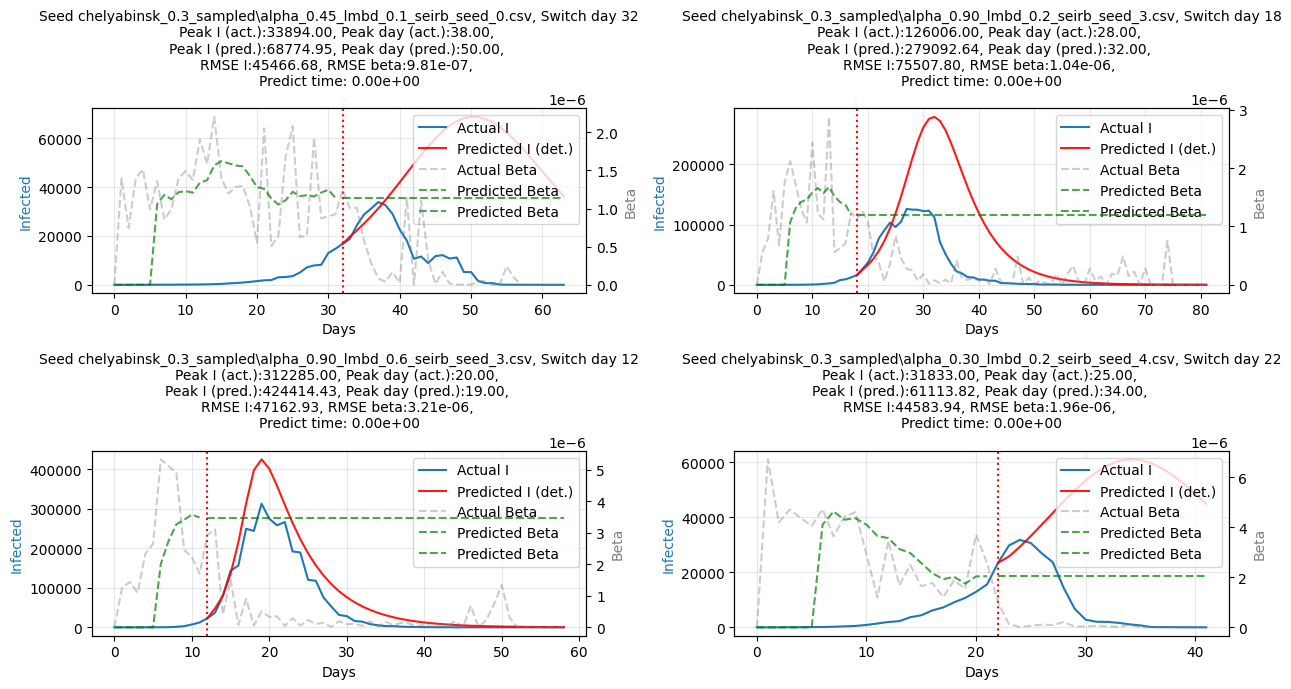

expanding mean last value 


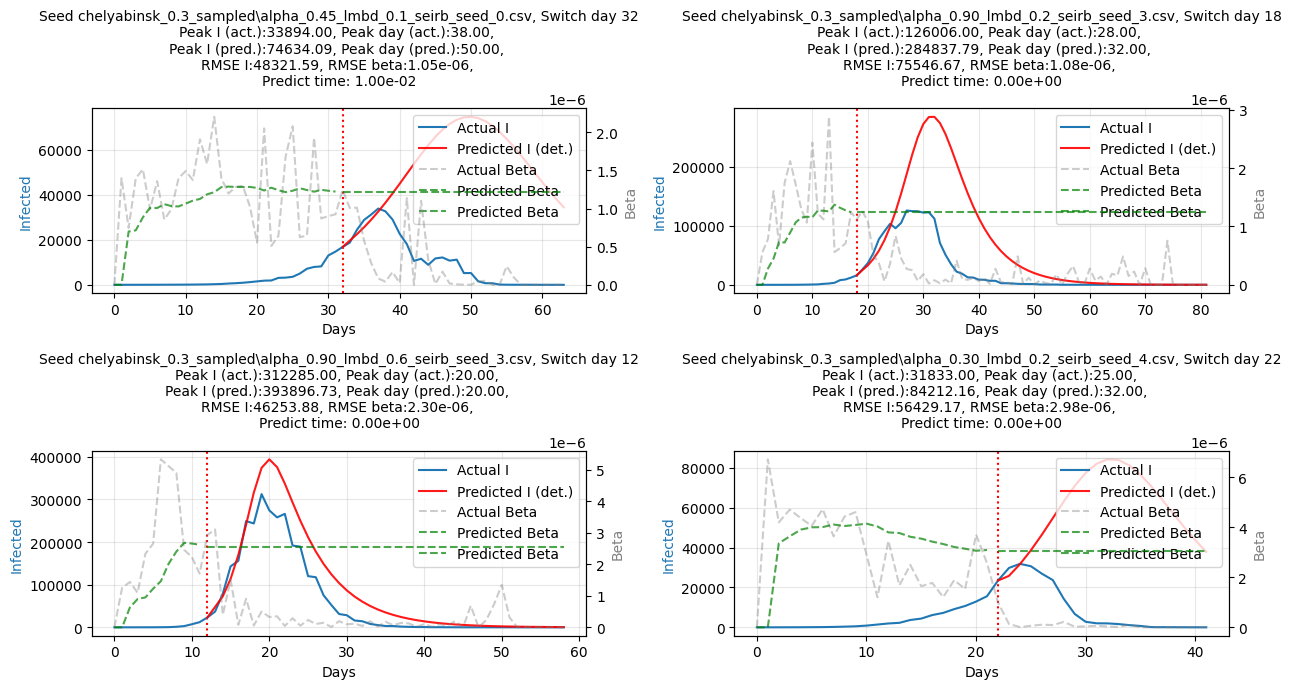

biexponential decay 


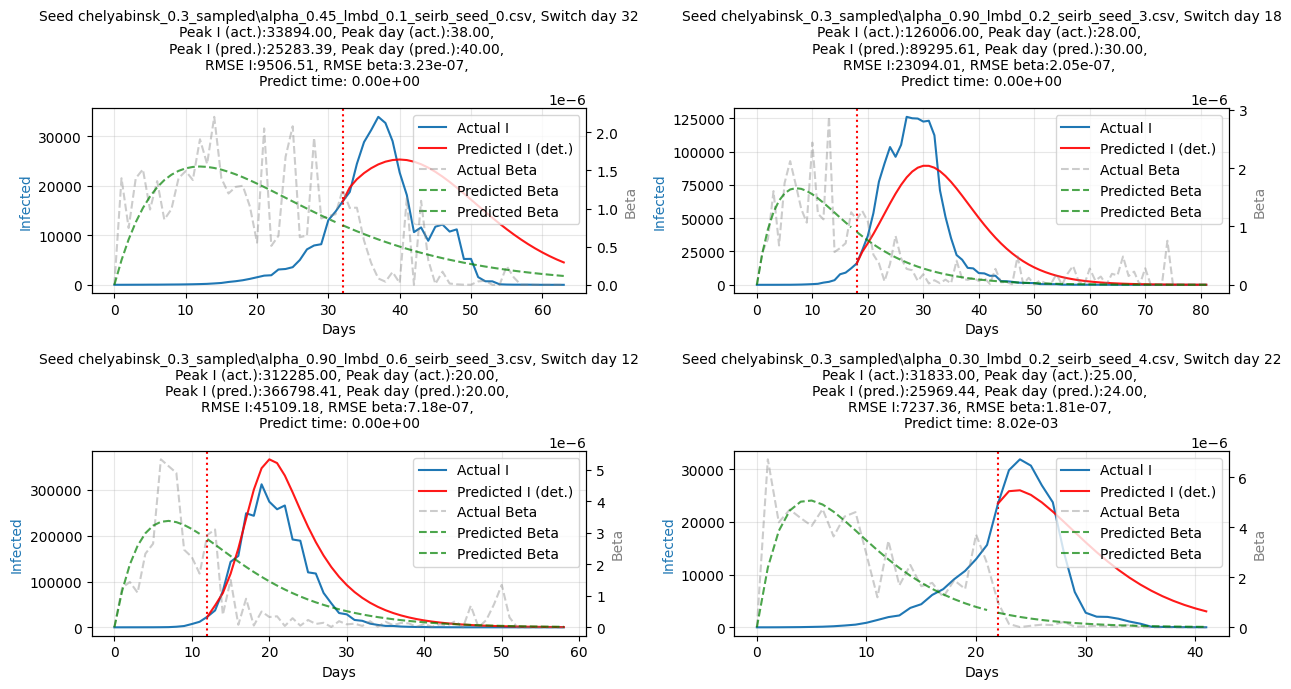

median beta chel_03_median_beta.csv


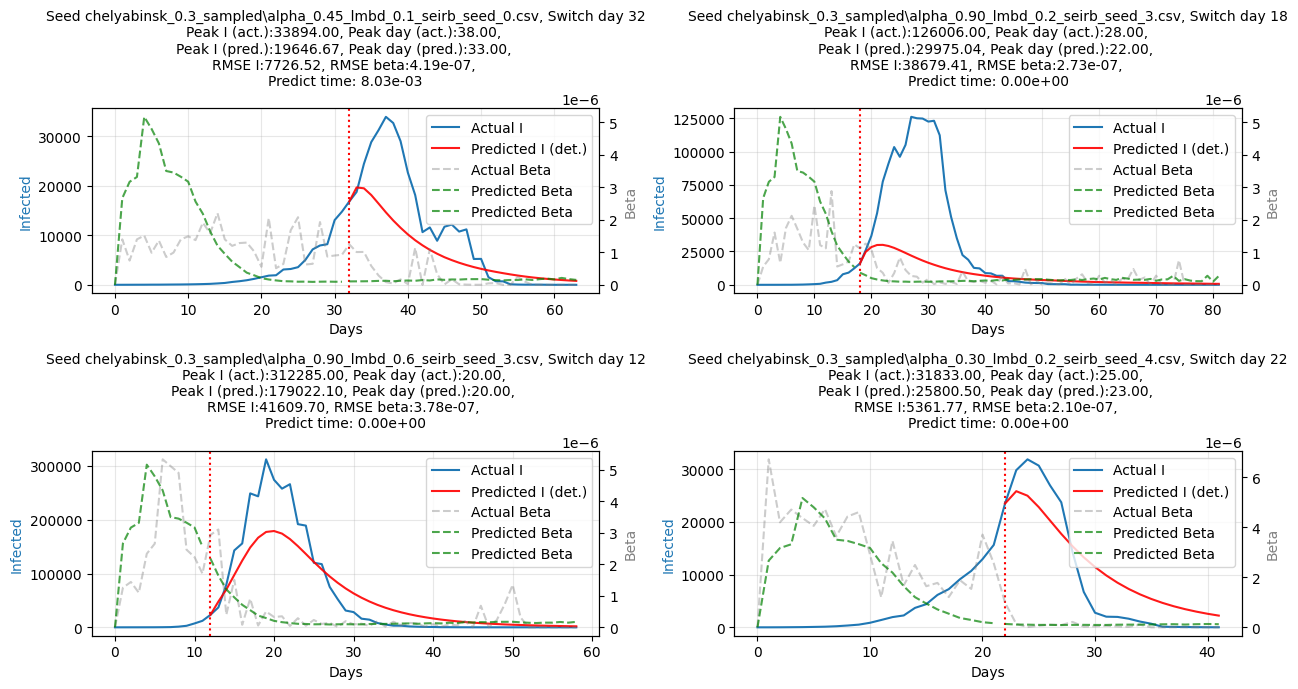

median beta;
shifted forecast chel_03_median_beta.csv


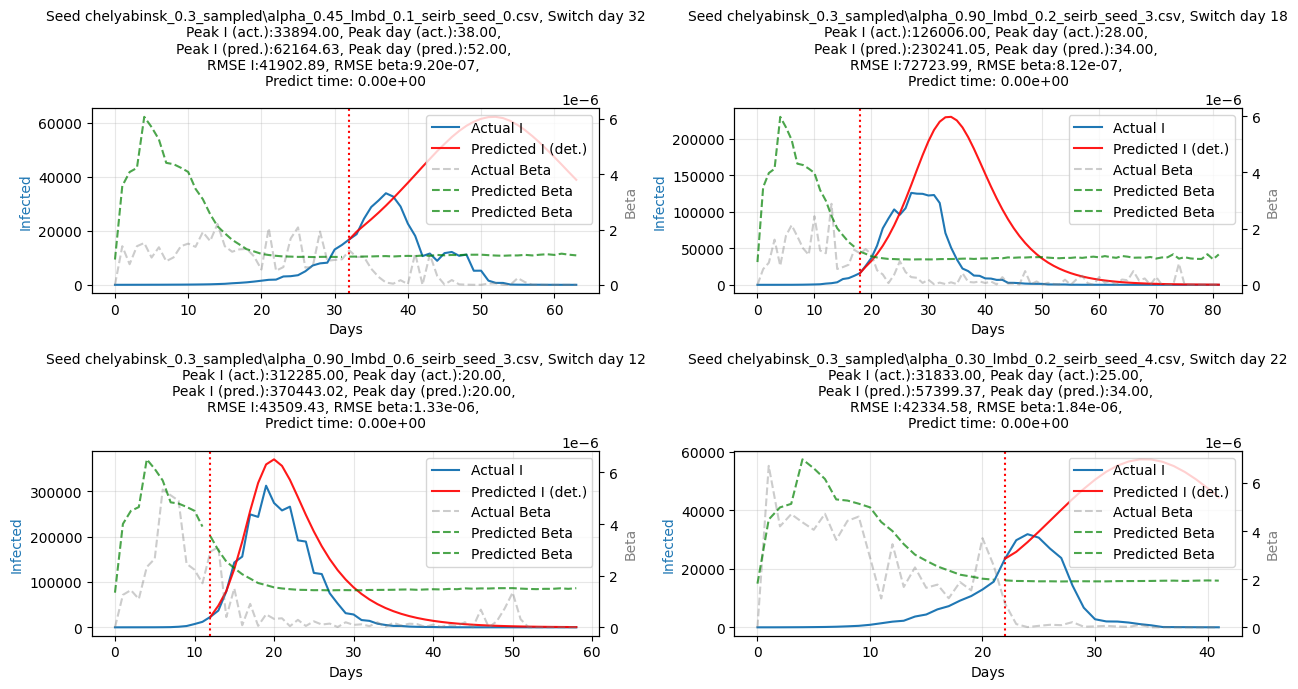

regression (day) chel_03_regression_day_for_seir.joblib


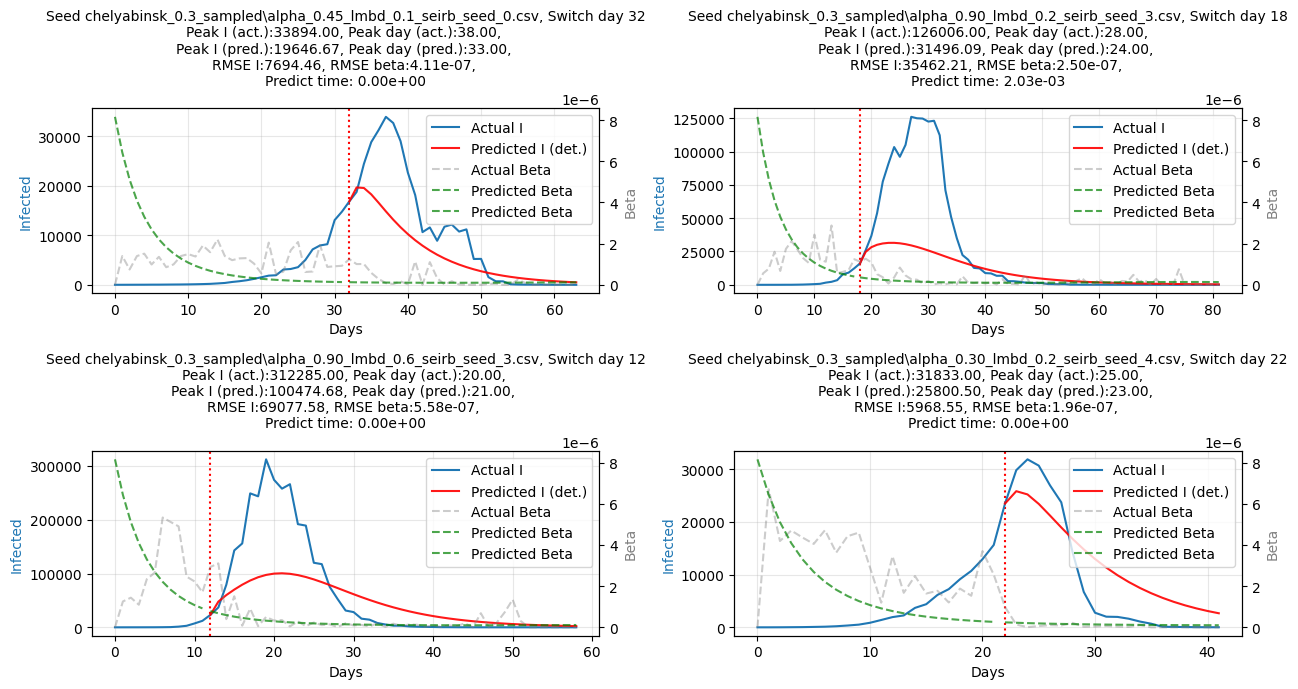

regression (day);
shifted forecast chel_03_regression_day_for_seir.joblib


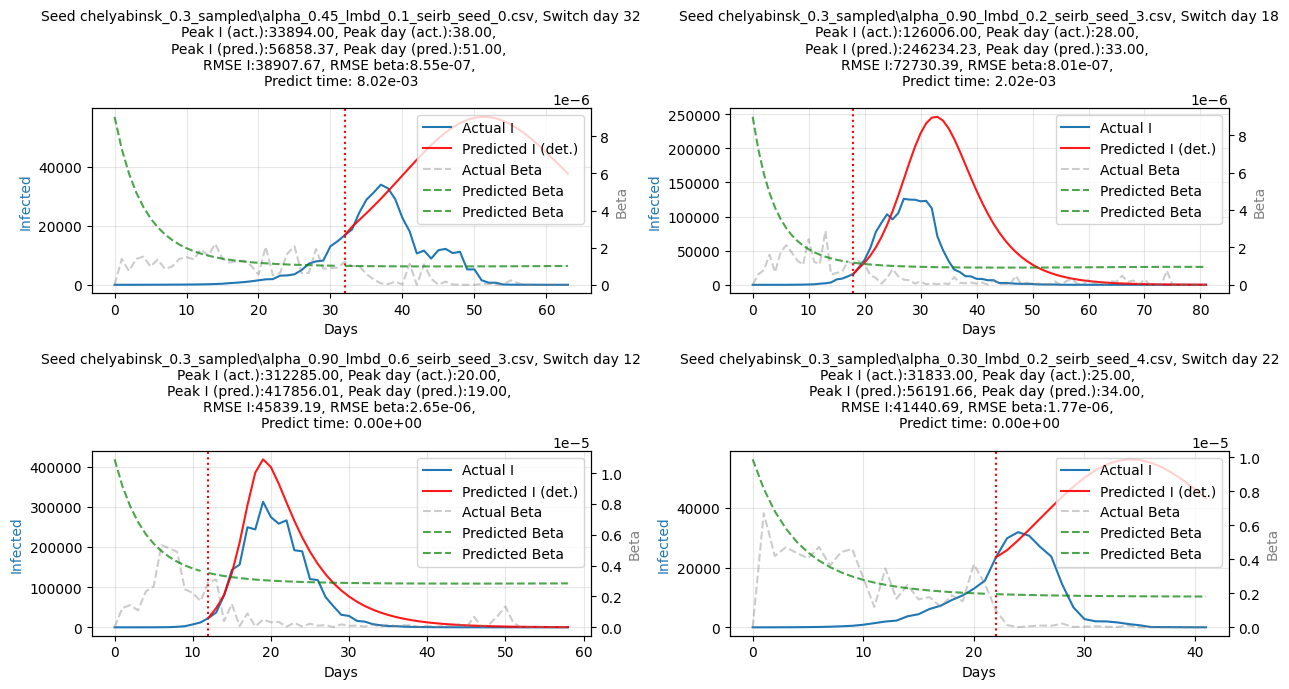

regression (day);
incremental learning chel_03_regression_day_for_seir.joblib


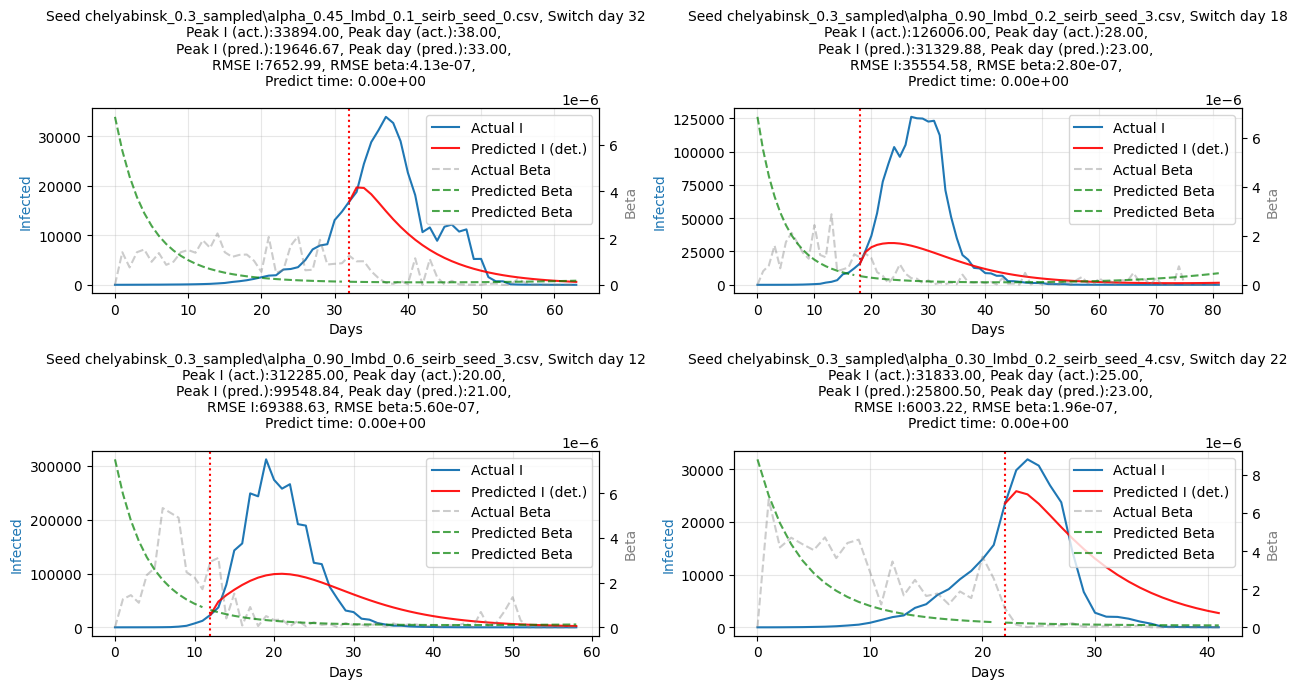

regression (day, SEIR, previous I) chel_03_regression_day_SEIR_prev_I_for_seir.joblib


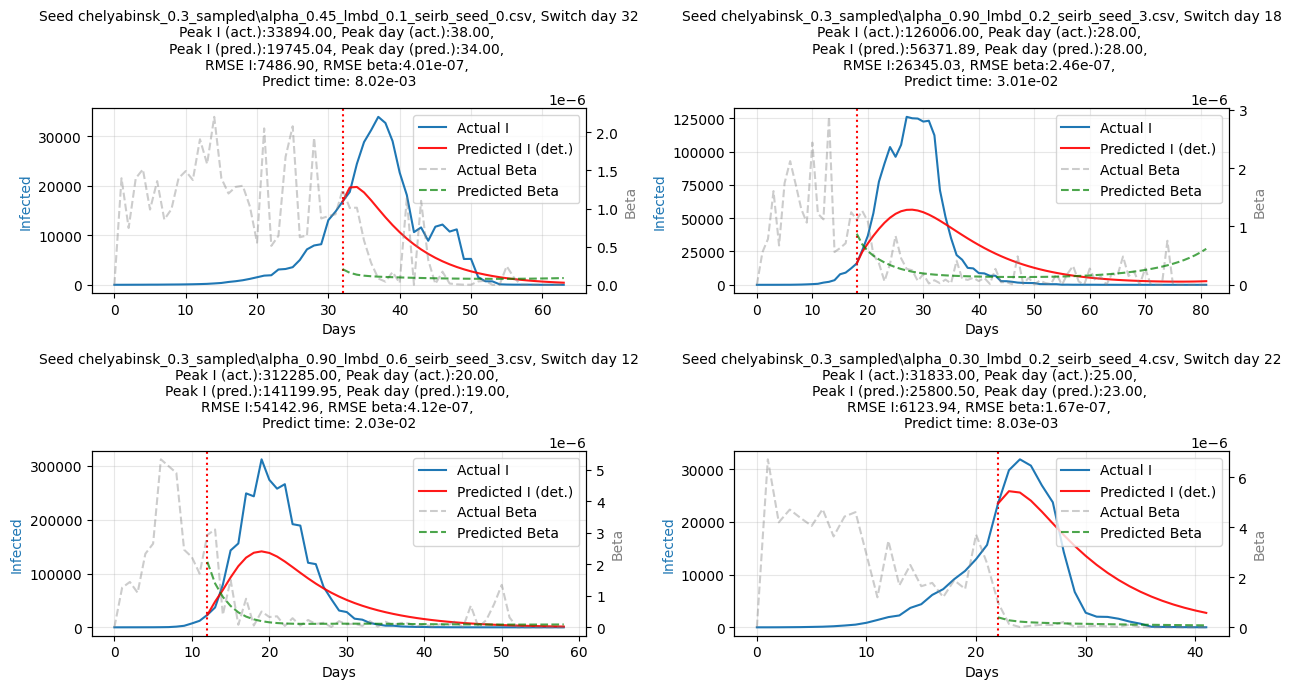

In [78]:
methods = ['last value', 'rolling mean last value',
           'expanding mean last value', 'biexponential decay',
            'median beta', 
               'median beta;\nshifted forecast',
           'regression (day)', 
            'regression (day);\nshifted forecast',
           'regression (day);\nincremental learning',
           'regression (day, SEIR, previous I)'
          ]

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value', 'biexponential_decay', 
                'median_beta', 'median_beta_shifted_forecast',
              'regression_day', 
               'regression_day_shifted_forecast',
              'regression_day_incremental_learning',
              'regression_day_SEIR_previous_I'
             ]

seed_numbers = X_test.values.flatten()[:4]
type_start_day = 'fraq_people' # 2 percents

for beta_pred, new_label in zip(methods, new_labels):
    if 'median' in beta_pred:
        model_path = 'chel_03_median_beta.csv'
    elif 'regression (day)' in beta_pred: 
        model_path = 'chel_03_regression_day_for_seir.joblib'
    elif '(day, SEIR, previous I)' in beta_pred:
        model_path = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'
    else:
        model_path=''
        
    all_rmse_I, all_rmse_Beta, \
        all_peak, execution_time, \
            start_days = plot_hyb.main_f(I_prediction_method='seir', 
                                stochastic=False, count_stoch_line=0, 
                                beta_prediction_method=beta_pred, 
                                type_start_day=type_start_day, 
                                seed_numbers=seed_numbers, 
                                show_fig_flag=True,
                                seed_dirs='chelyabinsk_0.3_sampled/', 
                                sigma=1/2, gamma=1/6, model_path=model_path)
    # creating a dataframe for peaks
    all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 
                                               'predicted_peak_I', 
                                               'actual_peak_day', 
                                               'predicted_peak_day'])

    rmse_df = pd.DataFrame({
        'rmse_I': all_rmse_I,
        'rmse_Beta': all_rmse_Beta,
        'time_predict': execution_time,
        'day': start_days})

    #features_reg = ['day','prev_I','S','E','I','R']

In [12]:
methods = ['last value', 'rolling mean last value',
           'expanding mean last value', 'biexponential decay',
            'median beta', 
               'median beta;\nshifted forecast',
           'regression (day)', 
            'regression (day);\nshifted forecast',
           'regression (day);\nincremental learning',
           'regression (day, SEIR, previous I)',
           'lstm (day, E, previous I)'
          ]

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value', 'biexponential_decay', 
                'median_beta', 'median_beta_shifted_forecast',
              'regression_day', 
               'regression_day_shifted_forecast',
              'regression_day_incremental_learning',
              'regression_day_SEIR_previous_I',
              'lstm_day_E_previous_I'
             ]

seed_numbers = X_test.values.flatten()
type_start_day = 'fraq_people' # 1 perc

for beta_pred, new_label in zip(methods[10:], new_labels[10:]):
    if 'median' in beta_pred:
        model_path = 'chel_03_median_beta.csv'
    elif 'regression (day)' in beta_pred: 
        model_path = 'chel_03_regression_day_for_seir.joblib'
    elif '(day, SEIR, previous I)' in beta_pred:
        model_path = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'
    elif 'lstm' in beta_pred:
        model_path = 'chel_03_lstm_day_E_prev_I_for_seir'
    else:
        model_path=''
        
    all_rmse_I, all_rmse_Beta, \
        all_peak, execution_time, \
            start_days = plot_hyb.main_f(I_prediction_method='seir', 
                                stochastic=False, count_stoch_line=0, 
                                beta_prediction_method=beta_pred, 
                                type_start_day=type_start_day, 
                                seed_numbers=seed_numbers, 
                                show_fig_flag=False,
                                seed_dirs='chelyabinsk_0.3_sampled/', 
                                sigma=1/2, gamma=1/6, model_path=model_path)
    # creating a dataframe for peaks
    all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 
                                               'predicted_peak_I', 
                                               'actual_peak_day', 
                                               'predicted_peak_day'])

    rmse_df = pd.DataFrame({
        'rmse_I': all_rmse_I,
        'rmse_Beta': all_rmse_Beta,
        'time_predict': execution_time,
        'day': start_days})

    # merging dataframes
    results = pd.concat([rmse_df, all_peak], axis=1)
    results.to_csv('results/chel_diff/'+ \
                   f'start_{type_start_day}_{new_label}_results.csv',
                   index=False)

[autoreload of predict_Beta_I failed: Traceback (most recent call last):
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\encodings\cp1251.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 13206: character maps to <undefined>
]


lstm (day, E, previous I) chel_03_lstm_day_E_prev_I_for_seir


In [13]:
methods = [['$\mathregular{M_{last\_val}}$', '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$','$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$','$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',    
    '$\mathregular{M_{LSTM}}$'
    ]]
new_labels = [['last_value','rolling_mean_last_value',
    'expanding_mean_last_value','biexponential_decay'], 

    ['median_beta','regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I'
    ]]

[autoreload of predict_Beta_I failed: Traceback (most recent call last):
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\user\anaconda3\envs\abm_seir\Lib\encodings\cp1251.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 13206: character maps to <undefined>
]


Median RMSE I for last_value 53848.425470884686
Median RMSE I for rolling_mean_last_value 51979.250627713685
Median RMSE I for expanding_mean_last_value 53114.39565071131
Median RMSE I for biexponential_decay 33656.09468185326
Median RMSE I for median_beta 24196.381643540455
Median RMSE I for regression_day 30531.653068705993
Median RMSE I for median_beta_shifted_forecast 50119.329346030325
Median RMSE I for regression_day_shifted_forecast 51179.36811015538
Median RMSE I for regression_day_incremental_learning 31507.825885294587
Median RMSE I for regression_day_SEIR_previous_I 26720.857323162607
Median RMSE I for lstm_day_E_previous_I 27773.47988147674


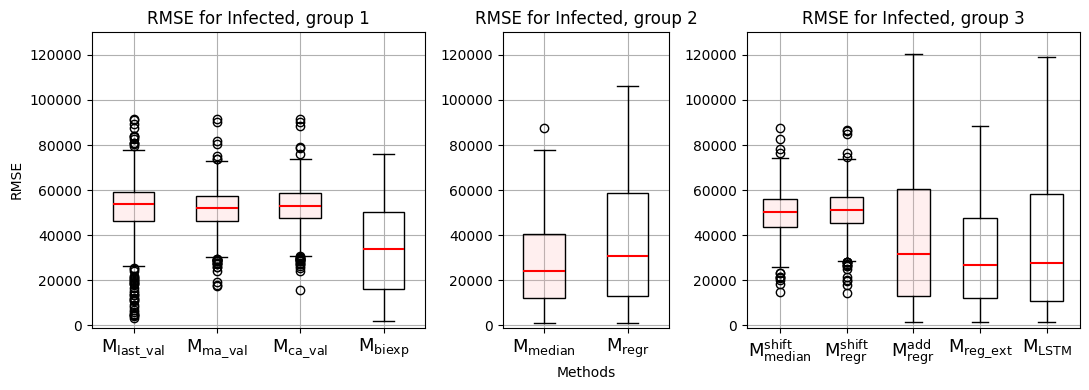

In [14]:
rmse_df = pd.DataFrame()

fig = plt.figure(figsize=(11, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.]) 


for i in range(len(methods)): 
    rmse_df = pd.DataFrame()
    
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/chel_diff/'+ \
                   f'start_{type_start_day}_{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
        print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
    
    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=True, 
                      medianprops=dict(color='red',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (1.0, 0.7, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
    ax.set_ylim(-1000,130000)
    ax.set_title(f'RMSE for Infected, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.grid()  

plt.tight_layout()
plt.savefig(f'results/chel_diff/start_day = {type_start_day}001_rmse_I_boxplot.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')    

Median RMSE I for last_value 2.8049321067419003e-06
Median RMSE I for rolling_mean_last_value 4.0038089669739975e-06
Median RMSE I for expanding_mean_last_value 3.4928513769830527e-06
Median RMSE I for biexponential_decay 5.973751428910552e-07
Median RMSE I for median_beta 4.5953967167757815e-07
Median RMSE I for regression_day 6.26611596404741e-07
Median RMSE I for median_beta_shifted_forecast 1.9233958764222145e-06
Median RMSE I for regression_day_shifted_forecast 3.2065626828642513e-06
Median RMSE I for regression_day_incremental_learning 6.371319247614843e-07
Median RMSE I for regression_day_SEIR_previous_I 5.120651953133072e-07
Median RMSE I for lstm_day_E_previous_I 6.002482598786325e-07


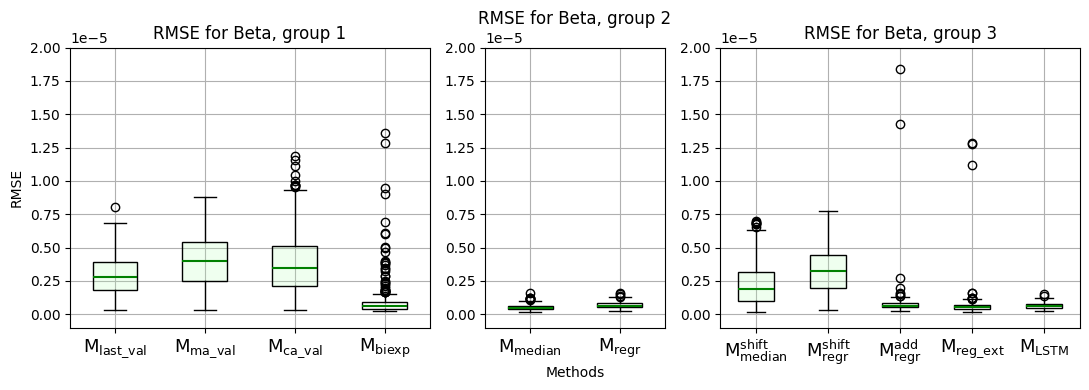

In [15]:
rmse_df = pd.DataFrame()

fig = plt.figure(figsize=(11, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.]) 


for i in range(len(methods)): 
    rmse_df = pd.DataFrame()
    
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/chel_diff/'+ \
                   f'start_{type_start_day}_{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']
        print(f'Median RMSE I for {new_label}', df['rmse_Beta'].median())
    
    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=True, 
                      medianprops=dict(color='green',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (0.7, 1.0, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
    ax.set_ylim(-1e-6,2e-5)
    ax.set_title(f'RMSE for Beta, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.grid()  

plt.tight_layout()
plt.savefig(f'results/chel_diff/start_day = {type_start_day}001_rmse_B_boxplot.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')    

<Axes: >

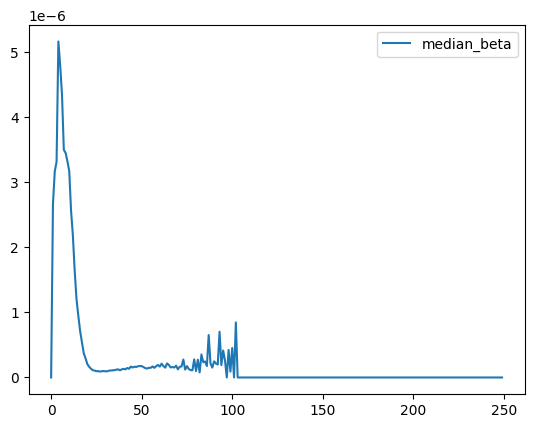

In [102]:
betas = pd.DataFrame()

for i in X_train.values.flatten():
    df = pd.read_csv(i)
    seed_df = pd.read_csv(i)
    df = seed_df.iloc[:,:5].copy()
    df.columns = ['S','E','I','R','Beta']
    
    epidemic_end = df[(df['E'] == 0) & (df['I'] == 0)].index
    if epidemic_end.shape[0] > 1:
        df.loc[epidemic_end[0]:, 'Beta'] = -2 
    
    df = df[['Beta']]
    df.columns = [i]  # Переименовываем колонку 'Beta' в номер сида
    betas = pd.concat([betas, df], axis=1)

median_beta = betas[betas > 0].median(axis=1)
#median_beta.fillna(0).to_csv('chel_03_median_beta.csv', header=['median_beta'])

pd.read_csv('chel_03_median_beta.csv', index_col=0).plot()

## 2nd group

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
import joblib

In [66]:
X_train.values.flatten().shape

(1042,)

In [107]:
X_test.values.flatten().shape

(326,)

In [109]:
X_val.values.flatten().shape

(261,)

In [67]:
def load_and_prepare_data(train_files, val_files):
    train_df = []
    for i in train_files:
        seed_df = pd.read_csv(i)
        seed_df = seed_df.iloc[:,:5].copy()
        seed_df.columns = ['S','E','I','R','Beta']
        seed_df['day'] = np.arange(len(seed_df))
        train_df.append(seed_df)
        
    for i in val_files:
        seed_df = pd.read_csv(i)
        seed_df = seed_df.iloc[:,:5].copy()
        seed_df.columns = ['S','E','I','R','Beta']
        seed_df['day'] = np.arange(len(seed_df))
        train_df.append(seed_df)
    
    train_df = pd.concat(train_df, ignore_index=True)
    #
    train_df = train_df[(train_df['E'] > 0)|(train_df['I'] > 0)].copy()
    train_df = train_df[train_df['Beta'] > 0].copy()
    train_df['Beta'].replace(0, 1e-7, inplace=True)
    train_df['log_Beta'] = np.log(train_df['Beta'])
    
    return train_df


def train_model(train_df, model_file):
    X = train_df[['day']].values
    y = train_df['log_Beta'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=3),
        SGDRegressor(alpha=0.1, max_iter=5000, penalty='l2', 
                     warm_start=False)
    )

    model.fit(X, y)

    joblib.dump(model, model_file)
    
train_files = X_train.values.flatten()
val_files = X_val.values.flatten()    

model_file = 'chel_03_regression_day_for_seir.joblib'
train_df = load_and_prepare_data(train_files, val_files)
train_model(train_df, model_file)

X = train_df[['day']].values
y = train_df['log_Beta'].values

model = joblib.load(model_file)
model.score(X, y)

0.4796185905764939

In [ ]:
seed_df = pd.read_csv(X_val.values.flatten()[0])

seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
seed_df['day'] = np.arange(len(seed_df))
seed_df

In [200]:
seed_df = pd.read_csv(X_val.values.flatten()[0])

seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
seed_df['prev_I'] = seed_df['I'].shift(-1).fillna(0)
seed_df['day'] = np.arange(len(seed_df))
seed_df

,S,E,I,R,Beta,prev_I,day
0,556718.0,7.0,10.0,238601.0,-0.000000e+00,10.0,0
1,556717.0,8.0,10.0,238601.0,1.796245e-07,17.0,1
2,556714.0,4.0,17.0,238601.0,3.169861e-07,18.0,2
3,556709.0,8.0,18.0,238601.0,4.989641e-07,21.0,3
4,556706.0,8.0,21.0,238601.0,2.566115e-07,26.0,4
...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,245
246,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,246
247,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,247
248,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,248


In [333]:
train_df = []
for i in train_files:
    seed_df = pd.read_csv(i)
    seed_df = seed_df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
    seed_df['day'] = np.arange(len(seed_df))
    train_df.append(seed_df)

for i in val_files:
    seed_df = pd.read_csv(i)
    seed_df = seed_df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
    seed_df['day'] = np.arange(len(seed_df))
    train_df.append(seed_df)

train_df = pd.concat(train_df, ignore_index=True)
train_df = train_df[(train_df['E'] > 0)|(train_df['I'] > 0)].copy()
train_df = train_df[train_df['Beta'] > 0].copy()
#train_df['Beta'].replace(0, 1e-8, inplace=True)
train_df['log_Beta'] = np.log(train_df['Beta'])
train_df

,S,E,I,R,Beta,prev_I,day,log_Beta
1,596477.0,15.0,10.0,198834.0,1.844162e-06,10.0,1,-13.203486
2,596467.0,21.0,14.0,198834.0,1.197528e-06,10.0,2,-13.635251
3,596438.0,39.0,25.0,198834.0,1.944879e-06,14.0,3,-13.150311
4,596380.0,87.0,35.0,198834.0,2.778669e-06,25.0,4,-12.793538
5,596353.0,85.0,64.0,198834.0,7.074250e-07,35.0,5,-14.161634
...,...,...,...,...,...,...,...,...
323884,273929.0,155.0,2400.0,518852.0,2.266402e-07,2544.0,39,-15.299902
323885,273928.0,150.0,1026.0,520232.0,3.558084e-09,2400.0,40,-19.454044
323886,273916.0,13.0,1119.0,520288.0,3.915018e-08,1026.0,41,-17.055861
323888,273906.0,10.0,230.0,521190.0,1.587342e-07,467.0,43,-15.656034


In [337]:
features = ['day', 
            'log_Beta',
            'prev_I', 
            'S', 
            'E', 
            'I', 
            'R'
           ]
train_model(train_df, model_file, features)

mf = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'
X = train_df[features].values
y = train_df['log_Beta'].values

model = joblib.load(mf)
model.score(X, y)

-7.704153891222238e+22

In [612]:
def load_and_prepare_data(train_files, val_files):
    train_df = []
    for i in train_files:
        seed_df = pd.read_csv(i)
        seed_df = seed_df.iloc[:,:5].copy()
        seed_df.columns = ['S','E','I','R','Beta']
        seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
        seed_df['day'] = np.arange(len(seed_df))
        train_df.append(seed_df)
    
    for i in val_files:
        seed_df = pd.read_csv(i)
        seed_df = seed_df.iloc[:,:5].copy()
        seed_df.columns = ['S','E','I','R','Beta']
        seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
        seed_df['day'] = np.arange(len(seed_df))
        train_df.append(seed_df)
    
    train_df = pd.concat(train_df, ignore_index=True)
    train_df = train_df[train_df['Beta'] > 0].copy()
    #train_df['Beta'].replace(0, 1e-8, inplace=True)
    train_df = train_df[(train_df['E'] > 0)|(train_df['I'] > 0)].copy()
    train_df['log_Beta'] = np.log(train_df['Beta'])
    
    return train_df


def train_model(train_df, model_file,features):
    X = train_df[features].values
    print(features)
    y = train_df['log_Beta'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=2),
        SGDRegressor(
                     alpha=0.1, 
                     max_iter=5000, 
                     penalty='l2',
                     #penalty=None,
                     warm_start=False)
    )
    model.fit(X, y)

    # Сохраняем лучшую модель
    joblib.dump(model, model_file)

    
train_files = X_train.values.flatten()
val_files = X_val.values.flatten()

model_file = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'

features = ['day',
            'prev_I', 
            'S', 
            'E', 
            'I', 
            'R',
           ]

train_df = load_and_prepare_data(train_files, val_files)
train_model(train_df, model_file, features)

mf = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'
X = train_df[features].values
y = train_df['log_Beta'].values

model = joblib.load(mf)
model.score(X, y)

['day', 'prev_I', 'S', 'E', 'I', 'R']


0.5646251365251008

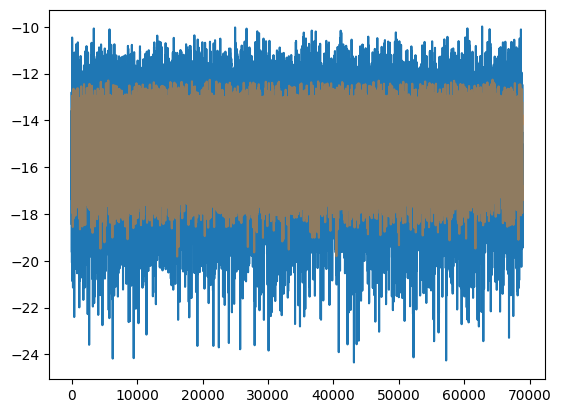

In [573]:
plt.plot(train_df['log_Beta'].values)
plt.plot(model.predict(X), alpha=0.5)

In [490]:
q = PolynomialFeatures(include_bias=False, degree=2)
q.fit_transform( np.array([2,3]).reshape(1, -1) )

array([[2., 3., 4., 6., 9.]])

array([2.29128965e+11, 2.17559011e+11, 2.21911942e+11, ...,
       2.29128965e+11, 2.29128965e+11, 2.29128965e+11])

Text(0, 0.5, 'logbeta')

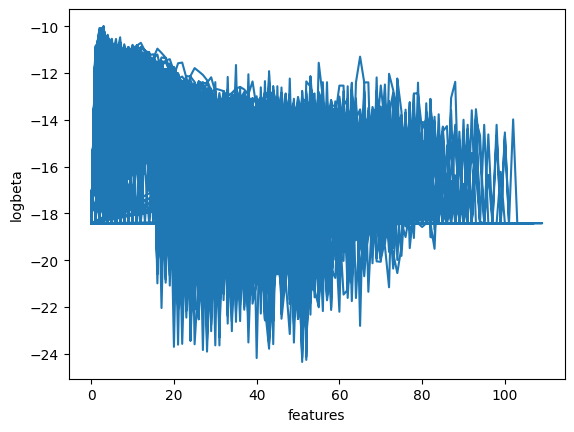

In [478]:
plt.plot(train_df[features].values,
         train_df['log_Beta'].values);

plt.xlabel('features')
plt.ylabel('logbeta')

In [397]:
X.shape

(68902, 1)

In [387]:
features

['Beta']

In [388]:
np.log(train_df[features].values).shape

(68902, 1)

In [389]:
train_df[['log_Beta']].values.shape

(68902, 1)

In [391]:
(np.log(train_df[features].values) == train_df[['log_Beta']].values).sum()

np.int64(68902)

In [393]:
(np.log(train_df[['Beta']].values) == train_df[['log_Beta']].values).sum()

np.int64(68902)

In [297]:
X = train_df[features].iloc[:50].values
y = train_df['log_Beta'].iloc[:50].values


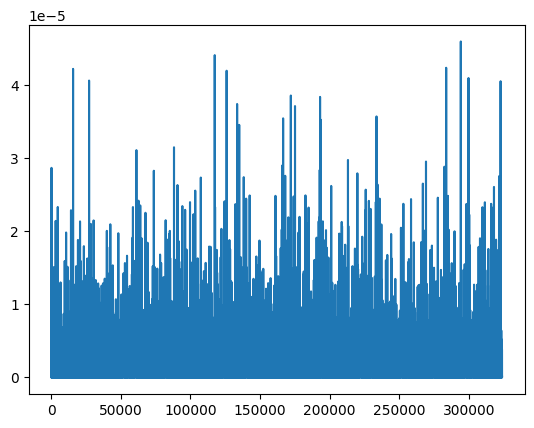

In [299]:
plt.plot(train_df['Beta'])

In [174]:
seed_df.iloc[2].drop(['day','Beta']).values

array([5.56714e+05, 4.00000e+00, 1.70000e+01, 2.38601e+05, 1.80000e+01])

In [264]:
model_file = 'regression_day_SEIR_prev_I_for_seir.joblib'
m = joblib.load(model_file)
m

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('sgdregressor', SGDRegressor(alpha=0.1, max_iter=5000))])

In [212]:
seed_df = pd.read_csv(X_val.values.flatten()[0])

seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
seed_df['day'] = np.arange(len(seed_df))
seed_df

,S,E,I,R,Beta,prev_I,day
0,556718.0,7.0,10.0,238601.0,-0.000000e+00,0.0,0
1,556717.0,8.0,10.0,238601.0,1.796245e-07,10.0,1
2,556714.0,4.0,17.0,238601.0,3.169861e-07,10.0,2
3,556709.0,8.0,18.0,238601.0,4.989641e-07,17.0,3
4,556706.0,8.0,21.0,238601.0,2.566115e-07,18.0,4
...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,245
246,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,246
247,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,247
248,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,248


In [213]:
ш =4
np.array([i, seed_df.iloc[i]['prev_I'],
                        *seed_df.iloc[i].drop(['day','Beta','prev_I']
                                             ).values]
              ).reshape(1, -1)

array([[4.00000e+00, 1.80000e+01, 5.56706e+05, 8.00000e+00, 2.10000e+01,
        2.38601e+05]])

In [274]:
model_file = 'regression_day_SEIR_prev_I_for_seir.joblib'
m = joblib.load(model_file)

In [276]:
model_file = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'
m = joblib.load(model_file)

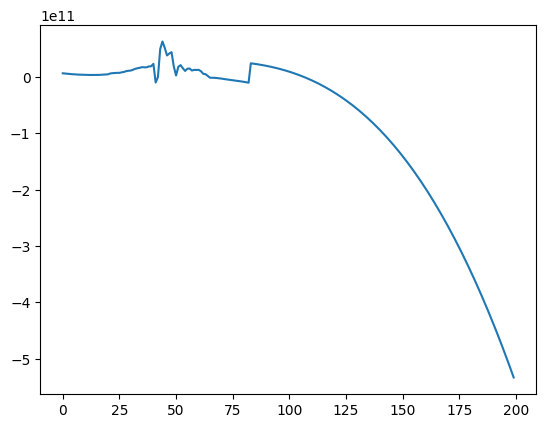

In [277]:
seed_df = pd.read_csv(X_val.values.flatten()[0])

seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
seed_df['day'] = np.arange(len(seed_df))
seed_df

r = []
for i in range(200):
    input_x = np.array([i, seed_df.iloc[i]['prev_I'],
                        *seed_df.iloc[i].drop(['day','Beta','prev_I']
                                             ).values]
              ).reshape(1, -1)
    r.append(m.predict(input_x))
    
plt.plot(r)

In [ ]:
seed_df = pd.read_csv(X_val.values.flatten()[0])
seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
seed_df['prev_I'] = seed_df['I'].shift(-1).fillna(0)
seed_df['day'] = np.arange(len(seed_df))
seed_df

,S,E,I,R,Beta,prev_I,day
0,556718.0,7.0,10.0,238601.0,-0.000000e+00,10.0,0
1,556717.0,8.0,10.0,238601.0,1.796245e-07,17.0,1
2,556714.0,4.0,17.0,238601.0,3.169861e-07,18.0,2
3,556709.0,8.0,18.0,238601.0,4.989641e-07,21.0,3
4,556706.0,8.0,21.0,238601.0,2.566115e-07,26.0,4
...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,245
246,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,246
247,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,247
248,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,248


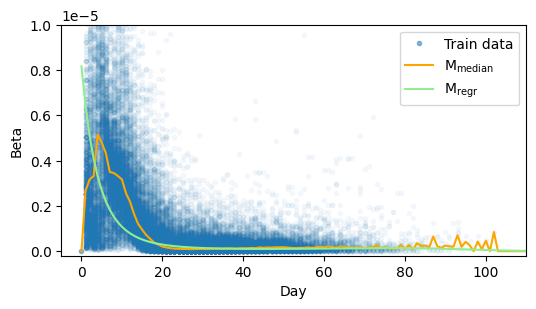

In [142]:
all_betas = pd.DataFrame()

for i in X_train.values.flatten():
    seed_df = pd.read_csv(i)
    df = seed_df.iloc[:,:5].copy()
    df.columns = ['S','E','I','R','Beta']
    
    epidemic_end = df[(df['E'] == 0) & (df['I'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'Beta'] = -2
    all_betas = pd.concat([all_betas, df[['Beta']]], axis=1)


fig = plt.figure(figsize=(6, 3)) 

plt.plot(all_betas.iloc[0,0], marker='.', ls='',alpha=0.5,
        label='Train data')
plt.plot(all_betas[all_betas>0], marker='.', ls='',alpha=0.04,
        color='tab:blue');

plt.plot(pd.read_csv('chel_03_median_beta.csv', index_col=0),  
         ls='-', color='orange', 
         label='$\mathregular{M_{median}}$')

sigma = 0.1
gamma = 0.08
beggining_beta, predicted_beta, \
    predicted_I = predict_Beta_I.predict_beta(
        'seir', df, 'regression (day)', 
        np.arange(30, df.shape[0]), False, 0, sigma, gamma,
        features_reg = [], 
        model_path='chel_03_regression_day_for_seir.joblib')

plt.plot(df.index.values, 
         np.concatenate((beggining_beta, predicted_beta)),
         ls='-', color='lightgreen', 
         label='$\mathregular{M_{regr}}$')


plt.legend()
plt.xlabel('Day')
plt.ylabel('Beta')

plt.ylim(-2e-7, 1e-5)
plt.xlim(-5, 110)

plt.legend()
plt.savefig(f'results/chel_diff/Beta_trajectories.png', format='png',  bbox_inches='tight') 

In [80]:
seed_df = seed_df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']

In [86]:
predicted_days

array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 19

In [ ]:
count_stoch_line = 0
stochastic=False
I_prediction_method = 'seir'

                       
start_day = 15
predicted_days = np.arange(start_day, seed_df.shape[0])
predicted_I = np.zeros((count_stoch_line+1, predicted_days.shape[0]))
model_path = 'chel_03_regression_day_SEIR_prev_I_for_seir.joblib'



predicted_beta = np.empty((0,))
S = np.zeros((count_stoch_line+1, 2))
E = np.zeros((count_stoch_line+1, 2))
R = np.zeros((count_stoch_line+1, 2))

S[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['S']
predicted_I[0:count_stoch_line+1,
            0] = seed_df.iloc[predicted_days[0]]['I']
R[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['R']  
E[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['E'] 

total_len = 5#len(features_reg)  

features_reg = ['day','S','E','I','R','prev_I']

y = np.array([S[:,0], E[:,0], predicted_I[:,0], R[:,0]])
y = y.T
model = joblib.load(model_path)
prev_I = seed_df.iloc[predicted_days[0]-1:predicted_days[0]
                     ]['I'
                      ].to_numpy() if predicted_days[0] > 1 else np.array([0.0, 0.0])
var_dict = {
            'day': predicted_days[0],
            'S': S[0, 0],
            'E': E[0, 0],
            'I': predicted_I[0, 0],
            'R': R[0, 0] ,
            'prev_I': prev_I[0]
            }
X_input = [var_dict[feature] for feature in features_reg]
log_beta = model.predict([X_input])
beta = np.exp(log_beta)[0]
predicted_beta = np.append(predicted_beta,max(beta, 0))

for idx in range(predicted_days.shape[0]-1):

    # prediction of the Infected compartment trajectory
    S[0,:], E[0,:], predicted_I[0,idx:idx+2], \
        R[0,:] =  predict_Beta_I.predict_I(
                                  I_prediction_method, y[0], 
                                  predicted_days[idx:idx+2], 
                                  predicted_beta[idx], sigma, gamma, 
                                  'det', beta_t=False)   

    y = np.array([S[:,1], E[:,1], predicted_I[:,idx+1], R[:,1]])
    y = y.T

    var_dict = {
        'day': predicted_days[idx+1],
        'S': S[0, 1],
        'E': E[0, 1],
        'I': predicted_I[0, idx+1],
        'R': R[0, 1] ,
        'prev_I': predicted_I[0,idx]
        }
    
    X_input = [var_dict[feature] for feature in features_reg]
    log_beta = model.predict([X_input])
    beta = np.exp(log_beta)[0]
    predicted_beta = np.append(predicted_beta, max(beta, 0))

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
predicted_beta

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
seed_df

,S,E,I,R,Beta
0,477171.0,21.0,10.0,318134.0,-0.000000e+00
1,477168.0,24.0,10.0,318134.0,6.287094e-07
2,477134.0,37.0,31.0,318134.0,2.298671e-06
3,477086.0,82.0,34.0,318134.0,2.959141e-06
4,476979.0,155.0,68.0,318134.0,3.298949e-06
...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,-0.000000e+00
246,0.0,0.0,0.0,0.0,-0.000000e+00
247,0.0,0.0,0.0,0.0,-0.000000e+00
248,0.0,0.0,0.0,0.0,-0.000000e+00


In [108]:
range(predicted_days.shape[0]-2)

range(0, 233)

In [105]:
S[0,:], E[0,:], predicted_I[0,idx:idx+2], \
        R[0,:]

(array([405800., 405800.]),
 array([4.32468936e-06, 3.89222043e-06]),
 array([0.00292521]),
 array([389535.99681615, 389535.99707047]))

In [106]:
idx

219

In [107]:
idx=219
predicted_I[0,idx:idx+2]

array([0.00292521])

## lstm

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import time
import tensorflow
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [12]:
###############################################################################
# 1. Data preparation
###############################################################################
def create_sequences(data, window_size):
    """
    Convert a multivariate sequence into samples of shape (window_size, n_features).
    The target is the last column (log_beta).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :-1])  # use first 6 features as input
        y.append(data[i + window_size, -1])         # predict normalized log_beta
    
    return np.array(X), np.array(y)


def load_and_prepare_data(df_files, window_size, scaler = None):
    """
    Loads CSV files, applies shift(-2) for 'prev_I', computes log(Beta) for 'log_beta',
    and fits a global scaler on all 7 columns.
    Returns training sequences, targets, and the scaler.
    """
    if scaler == None:
        train_df = []
        
        # First pass: collect data for scaling
        for file in df_files:
            try:
                seed_df = pd.read_csv(file)
                seed_df = seed_df.iloc[:,:5].copy()
                seed_df.columns = ['S','E','I','R','Beta']
                
                seed_df['day'] = range(len(seed_df))
                seed_df['prev_I'] = seed_df['I'].shift(2).fillna(0)
                seed_df['log_beta'] = np.log(seed_df['Beta'].clip(lower=1e-7))
                seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
                features = seed_df[['day','E', 'prev_I', 'log_beta']].values
                train_df.append(features)
            except Exception as e:
                print(f"Skipping seed {i}: {str(e)}")
                continue

        scaler = StandardScaler()
        if train_df:
            scaler.fit(np.concatenate(train_df))
        else:
            raise ValueError("No data collected for scaling. Please check your input files.")

    # Second pass: create training sequences
    all_X, all_y = [], []
    for file in df_files:
        try:
            seed_df = pd.read_csv(file)
            seed_df = seed_df.iloc[:,:5].copy()
            seed_df.columns = ['S','E','I','R','Beta']
            
            seed_df['day'] = range(len(seed_df))
            seed_df['prev_I'] = seed_df['I'].shift(2).fillna(0)
            seed_df['log_beta'] = np.log(seed_df['Beta'].clip(lower=1e-7))
            seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
            features = seed_df[['day', 'E', 'prev_I', 'log_beta']].values
            scaled_features = scaler.transform(features)
            X, y = create_sequences(scaled_features, window_size)
            all_X.append(X)
            all_y.append(y)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    if not all_X or not all_y:
        raise ValueError("No valid training data found. Please check your input files.")

    return np.concatenate(all_X), np.concatenate(all_y), scaler


###############################################################################
# 2. Simplified model architecture with Grid search hyperparameters
###############################################################################
def build_lstm_model(window_size, n_features,
                     lstm_units1=64, lstm_units2=64,
                     dropout_rate1=0.2, dropout_rate2=0.3,
                     optimizer='rmsprop', learning_rate=0.001):
    """
    Builds an LSTM model using the grid search best hyperparameters:
      - First LSTM layer units: 64 with recurrent dropout of 0.2
      - Second LSTM layer units: 64 with dropout of 0.3
      - Optimizer: rmsprop
    """
    inputs = Input(shape=(window_size, n_features))
    x = LSTM(lstm_units1, return_sequences=True, 
             recurrent_dropout=dropout_rate1, 
             activation='relu')(inputs)
    x = Dropout(dropout_rate1)(x)
    x = LSTM(lstm_units2, return_sequences=False, 
             activation='relu')(x)
    x = Dropout(dropout_rate2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate2)(x)
    
    outputs = Dense(1, activation='linear')(x)
    
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')
    return model

###############################################################################
# 3. Enhanced training configuration
###############################################################################
def lr_scheduler(epoch):
    """
    Applies learning rate decay after 20 epochs.
    """
    initial_lr = 0.001
    decay = 0.1 if epoch > 30 else 1.0
    return initial_lr * decay


def train_lstm_model(X_train, y_train, X_val, y_val, window_size):
    """
    Builds and trains the LSTM model with early stopping and a learning rate scheduler.
    """
    model = build_lstm_model(window_size=window_size, 
                             n_features=X_train.shape[2], 
                             learning_rate=0.001)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                               restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
        verbose=1, 
        shuffle=False
    )
    return model, history

###############################################################################
# 4. Training pipeline
###############################################################################
def train_and_save_model(train_files, val_files, model_save_path, 
                         scaler_save_path, window_size):
    print(f"Training LSTM model on {train_files.shape[0]} seeds...")
    start_time = time.time()
    
    X_train, y_train, scaler = load_and_prepare_data(train_files,  window_size)
    X_val, y_val, _ = load_and_prepare_data(val_files, window_size, 
                                            scaler = scaler)
    if len(X_train) == 0:
        raise ValueError("No valid training data found.")
    
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, window_size)
    
    model.save(model_save_path)
    joblib.dump(scaler, scaler_save_path)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f}s")
    
    # Plot training history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, training_time

###############################################################################



Training LSTM model on 1042 seeds...
Epoch 1/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2906 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 2/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1979 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 3/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1885 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 4/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1834 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 5/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1773 - val_loss: 0.1539 - learning_rate: 0.0010
Epoch 6/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1749 - val_loss: 0.1538 - learning_rate: 0.0010
Epoch 7/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1729 - val_loss: 0.1540 - learning_rate: 0.0010
Epoch 8/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1734 - val_loss: 0.1541 - learning_rate: 0.0010
Epoch 9/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1715 - val_l

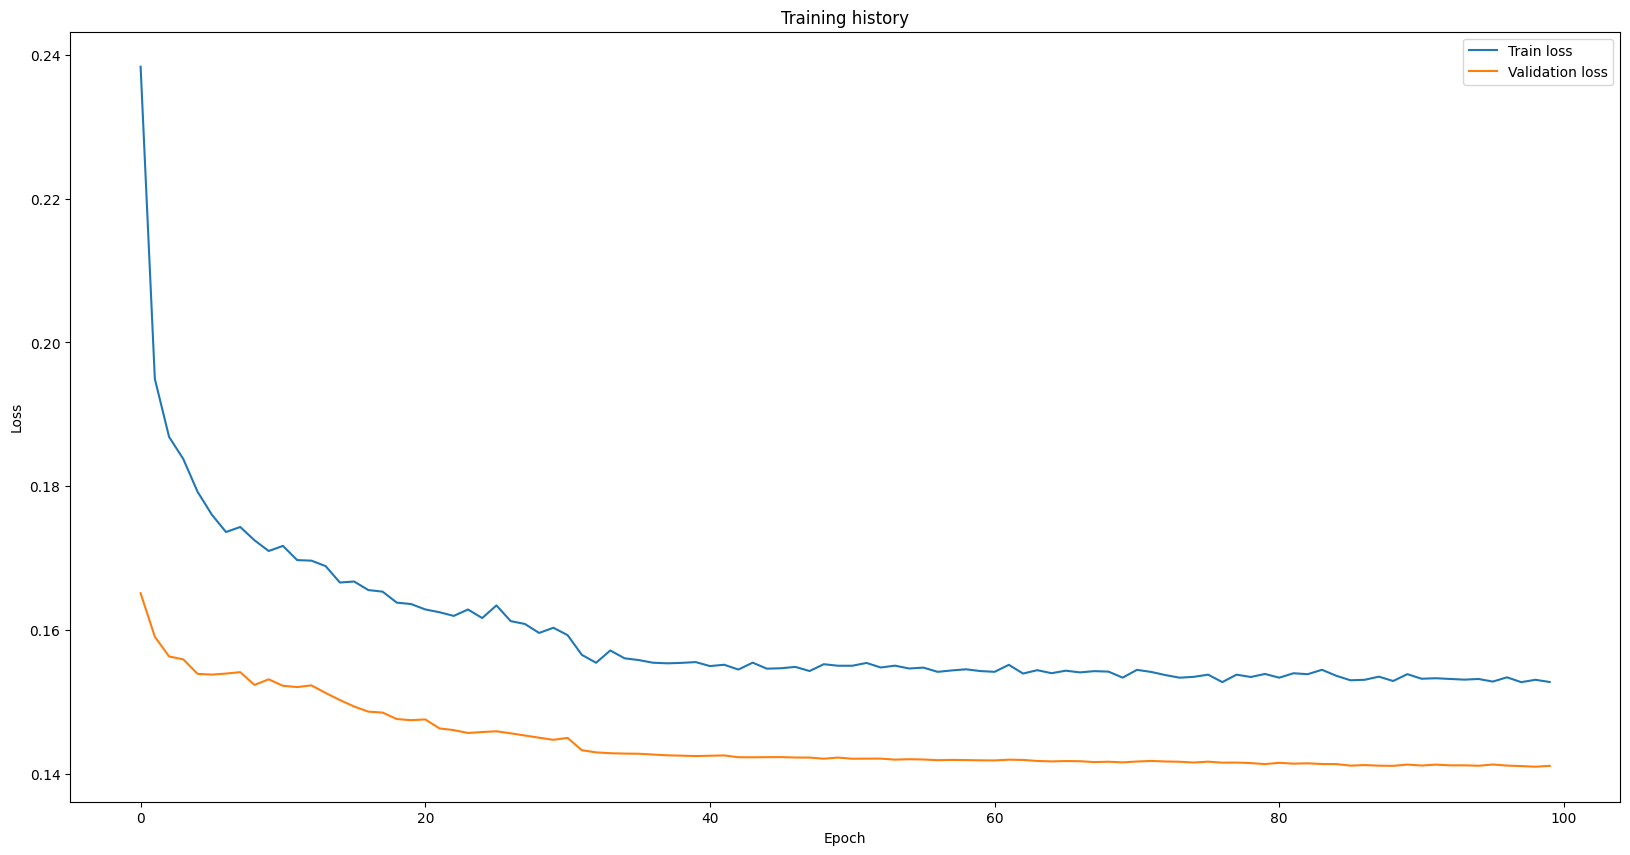

In [13]:
train_files = X_train.values.flatten()
val_files = X_val.values.flatten()

window_size = 14   # Must be the same for training and simulation
model_file = 'chel_03_lstm_day_E_prev_I_for_seir_a.keras'
scaler_file = 'chel_03_lstm_day_E_prev_I_for_seir_a.pkl'

model, scaler, _ = train_and_save_model(train_files, val_files,
                                        model_save_path=model_file, 
                                        scaler_save_path=scaler_file, 
                                        window_size=window_size)